In [1]:
import rasterio as rio
import numpy as np
import pandas as pd
import os
import xarray as xr
from dask.distributed import Client, LocalCluster
import dask

In [2]:
cluster = LocalCluster(n_workers=48, threads_per_worker=1, processes=True, memory_limit='32GB')

client = Client(cluster)
client

2023-05-05 16:54:24,249 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-3nfezpxa', purging
2023-05-05 16:54:24,249 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-0k7s2hi0', purging
2023-05-05 16:54:24,249 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-w9887n9g', purging
2023-05-05 16:54:24,249 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-g9o18x4h', purging
2023-05-05 16:54:24,249 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-rut_isvz', purging
2023-05-05 16:54:24,249 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1006/worker-in7l8g3o', purging
2023-05-05 16:54:24,250 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-s

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 48
Total threads: 48,Total memory: 1.40 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33365,Workers: 48
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 1.40 TiB
Comm: tcp://127.0.0.1:45713,Total threads: 1
Dashboard: http://127.0.0.1:38179/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:33363,


In [3]:
# combine IMERG-Final
from pathlib import Path

imerg_dir = Path(f"../../data-precip-analysis/imerg_final")
imerg_fn = imerg_dir / "imerg_final.nc"

imerg_ds = xr.open_mfdataset(imerg_fn, chunks={'time': 10}, parallel=True, engine='h5netcdf')
imerg_ds['time'] = [pd.to_datetime(str(time)) for time in imerg_ds['time'].data]
imerg_ds

<xarray.Dataset>
Dimensions:                    (time: 6744, lon: 683, lat: 311, nv: 2)
Coordinates:
  * lat                        (lat) float32 22.55 22.65 22.75 ... 53.45 53.55
  * lon                        (lon) float32 -126.5 -126.4 ... -58.45 -58.35
  * nv                         (nv) float32 0.0 1.0
  * time                       (time) datetime64[ns] 2000-06-01 ... 2021-09-30
Data variables:
    precipitationCal           (time, lon, lat) float32 dask.array<chunksize=(10, 683, 311), meta=np.ndarray>
    HQprecipitation            (time, lon, lat) float32 dask.array<chunksize=(10, 683, 311), meta=np.ndarray>
    precipitationCal_cnt       (time, lon, lat) int16 dask.array<chunksize=(10, 683, 311), meta=np.ndarray>
    randomError                (time, lon, lat) float32 dask.array<chunksize=(10, 683, 311), meta=np.ndarray>
    randomError_cnt            (time, lon, lat) int16 dask.array<chunksize=(10, 683, 311), meta=np.ndarray>
    time_bnds                  (time, nv) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    precipitationCal_cnt_cond  (time, lon, lat) int16 dask.array<chunksize=(10, 683, 311), meta=np.ndarray>
    HQprecipitation_cnt        (time, lon, lat) int16 dask.array<chunksize=(10, 683, 311), meta=np.ndarray>
    HQprecipitation_cnt_cond   (time, lon, lat) int16 dask.array<chunksize=(10, 683, 311), meta=np.ndarray>
Attributes:
    BeginDate:       2000-06-01
    BeginTime:       00:00:00.000Z
    EndDate:         2000-06-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2000-06-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20000601-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-18T20:51:50.167Z
    history:         2023-04-26 05:18:28 GMT Hyrax-1.16.3 https://gpm1.gesdis...

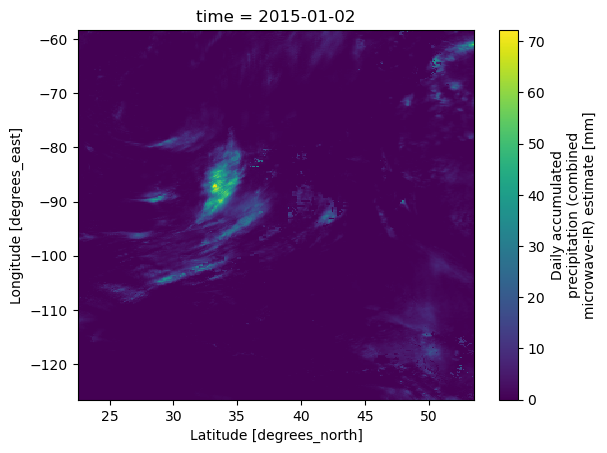

In [4]:
imerg_ds.sel(time='2015-01-02', method='nearest')['precipitationCal'].plot()

In [5]:
data_dir = Path(f"/home/pdas47/2023_01_24-river-regulation/data-precip-analysis")
data_dir.exists()

False

In [6]:
precip = imerg_ds['precipitationCal'].rename('precip').transpose('time', 'lat', 'lon')
precip

<xarray.DataArray 'precip' (time: 6744, lat: 311, lon: 683)>
dask.array<transpose, shape=(6744, 311, 683), dtype=float32, chunksize=(10, 311, 683), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 22.55 22.65 22.75 22.85 ... 53.25 53.35 53.45 53.55
  * lon      (lon) float32 -126.5 -126.4 -126.3 -126.2 ... -58.55 -58.45 -58.35
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-09-30
Attributes:
    units:         mm
    long_name:     Daily accumulated precipitation (combined microwave-IR) es...
    origname:      precipitationCal
    fullnamepath:  /precipitationCal

In [7]:
import rioxarray as rxr

In [8]:
# read tmax
tmax_dir = Path(f"../../data-cumberland/tennessee/basins/cumberland/pre_processing/processed/tmax/")
tmax_fns = list(tmax_dir.glob("*_TMAX.asc"))

@dask.delayed
def asc_to_ds(fn, name):
    da = rxr.open_rasterio(fn, masked=True).squeeze().drop('band')
    da.name = name
    time = pd.to_datetime(fn.stem.split('_')[0])
    # da['time'] = time

    da = da.expand_dims('time')
    da = da.rename({'x': 'lon', 'y': 'lat'})
    da = da.assign_coords(
        time = ('time', [time]),
        lon = ('lon', da.lon.values.round(5)),
        lat = ('lat', da.lat.values.round(5))
    )
    return da

tmax_ncs = [asc_to_ds(fn, 'tmax') for fn in tmax_fns]

tmax = dask.delayed(xr.concat)(tmax_ncs, dim='time')
tmax = dask.delayed(tmax.sortby)(['time'])
tmax

Delayed('sortby-04445c87-3663-4674-847b-19fafa3152e2')

In [9]:
tmax.compute()

<xarray.DataArray 'tmax' (time: 2382, lat: 35, lon: 89)>
array([[[32.726974 , 32.726974 , 32.726974 , ..., 32.96622  ,
         32.96622  , 32.96622  ],
        [32.726974 , 32.726974 , 32.726974 , ..., 32.96622  ,
         32.96622  , 32.96622  ],
        [32.726974 , 32.726974 , 32.726974 , ..., 32.96622  ,
         32.96622  , 32.96622  ],
        ...,
        [35.38555  , 35.38555  , 35.38555  , ..., 32.51163  ,
         32.51163  , 32.51163  ],
        [35.38555  , 35.38555  , 35.38555  , ..., 32.51163  ,
         32.51163  , 32.51163  ],
        [35.38555  , 35.38555  , 35.38555  , ..., 32.51163  ,
         32.51163  , 32.51163  ]],

       [[32.554665 , 32.554665 , 32.554665 , ..., 32.378525 ,
         32.378525 , 32.378525 ],
        [32.554665 , 32.554665 , 32.554665 , ..., 32.378525 ,
         32.378525 , 32.378525 ],
        [32.554665 , 32.554665 , 32.554665 , ..., 32.378525 ,
         32.378525 , 32.378525 ],
...
        [11.213681 , 11.213681 , 11.213681 , ..., 16.176367 ,
         16.176367 , 16.176367 ],
        [11.213681 , 11.213681 , 11.213681 , ..., 16.176367 ,
         16.176367 , 16.176367 ],
        [11.213681 , 11.213681 , 11.213681 , ..., 16.176367 ,
         16.176367 , 16.176367 ]],

       [[-3.6457896, -3.6457896, -3.6457896, ...,  7.0761695,
          7.0761695,  7.0761695],
        [-3.6457896, -3.6457896, -3.6457896, ...,  7.0761695,
          7.0761695,  7.0761695],
        [-3.6457896, -3.6457896, -3.6457896, ...,  7.0761695,
          7.0761695,  7.0761695],
        ...,
        [ 4.3758197,  4.3758197,  4.3758197, ..., 14.23855  ,
         14.23855  , 14.23855  ],
        [ 4.3758197,  4.3758197,  4.3758197, ..., 14.23855  ,
         14.23855  , 14.23855  ],
        [ 4.3758197,  4.3758197,  4.3758197, ..., 14.23855  ,
         14.23855  , 14.23855  ]]], dtype=float32)
Coordinates:
  * lon          (lon) float64 -88.28 -88.22 -88.16 ... -82.91 -82.84 -82.78
  * lat          (lat) float64 37.47 37.41 37.34 37.28 ... 35.47 35.41 35.34
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2016-07-25 2016-07-26 ... 2023-01-31
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [10]:
# tmax.load()
# dask.compute(tmax)

In [11]:
# read tmin
tmin_dir = Path(f"../../data-cumberland/tennessee/basins/cumberland/pre_processing/processed/tmin/")
tmin_fns = list(tmin_dir.glob("*_TMIN.asc"))

tmin_ncs = [asc_to_ds(fn, 'tmin') for fn in tmin_fns]

tmin = dask.delayed(xr.concat)(tmin_ncs, dim='time')
tmin = dask.delayed(tmin.sortby)(['time'])
tmin

Delayed('sortby-1b1214df-f689-4f07-bf94-2319a2a4e0f7')

In [12]:
# tmin.compute()

In [13]:
# read uwnd
uwnd_dir = Path(f"../../data-cumberland/tennessee/basins/cumberland/pre_processing/processed/uwnd/")
uwnd_fns = list(uwnd_dir.glob("*_UWND.asc"))

uwnd_ncs = [asc_to_ds(fn, 'uwnd') for fn in uwnd_fns]

uwnd = dask.delayed(xr.concat)(uwnd_ncs, dim='time')
uwnd = dask.delayed(uwnd.sortby)(['time'])
uwnd

# read vwnd
vwnd_dir = Path(f"../../data-cumberland/tennessee/basins/cumberland/pre_processing/processed/vwnd/")
vwnd_fns = list(vwnd_dir.glob("*_VWND.asc"))

vwnd_ncs = [asc_to_ds(fn, 'vwnd') for fn in vwnd_fns]

vwnd = dask.delayed(xr.concat)(vwnd_ncs, dim='time')
vwnd = dask.delayed(vwnd.sortby)(['time'])
vwnd

wind = (0.75 * dask.delayed(np.sqrt)(dask.delayed(np.power)(uwnd, 2) + dask.delayed(np.power)(vwnd, 2))).rename('wind')
wind

Delayed('rename-b472752f-e4ed-4f76-9a9a-18b045759e95')

In [14]:
# wind.compute()

In [15]:
# precip.compute()

In [16]:
# resample IMERG to match the other datasets
precip = dask.delayed(precip.interp)(lat=tmax.lat, lon=tmax.lon, method='nearest')
precip

Delayed('interp-4e601a75-a51a-4263-87c6-875d1b46a22c')

In [17]:
# precip.compute()

In [18]:
basin_gridpath = Path(f"../../data-precip-analysis/tennessee/basins/cumberland/basin_grid_data/cumberland_grid_mask.tif")
basin_grid = rxr.open_rasterio(basin_gridpath, masked=True).squeeze().drop('band')

extent_da = xr.DataArray(
    data = basin_grid.data,
    coords = dict(
        lat = (['lat'], precip.lat.compute().values),
        lon = (['lon'], precip.lon.compute().values)
    )
)
extent_da

<xarray.DataArray (lat: 35, lon: 89)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 37.47 37.41 37.34 37.28 ... 35.53 35.47 35.41 35.34
  * lon      (lon) float64 -88.28 -88.22 -88.16 -88.09 ... -82.91 -82.84 -82.78

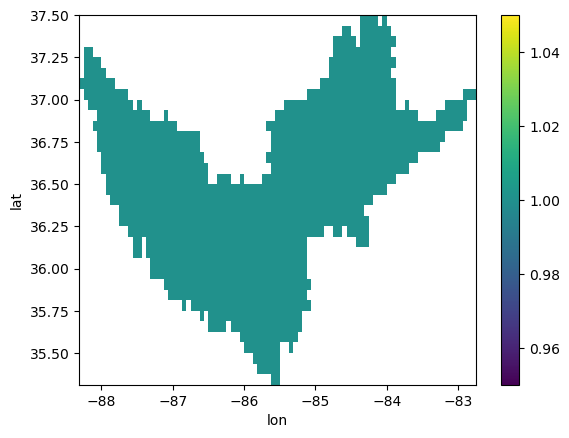

In [19]:
extent_da.plot()

In [20]:
ncpath_dir = Path(f"../../data-precip-analysis/tennessee/basins/cumberland/pre_processing/nc")
ncpath_dir.mkdir(exist_ok=True, parents=True)
ncpath = ncpath_dir / 'combined_data.nc'

def create_combined_nc(
        start: str, 
        end: str, 
        precip: xr.DataArray, 
        tmax: xr.DataArray, 
        tmin: xr.DataArray, 
        wind: xr.DataArray,
        extent: xr.DataArray
    ):
    # convert start and end dates to pd.Timestamp objects
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    date_range = pd.date_range(start, end)

    # check if ncpath exists. load in if it does and don't reprocess existing data.
    combined = xr.Dataset(
        data_vars=dict(
            precip = precip.sel(time=slice(start, end)).astype('float64'),
            tmax = tmax.sel(time=slice(start, end)).astype('float64'),
            tmin = tmin.sel(time=slice(start, end)).astype('float64'),
            wind = wind.sel(time=slice(start, end)).astype('float64'),
            extent = extent
        ),
        coords=dict(
            time = date_range,
            lon = precip.lon.round(5),
            lat = precip.lat.round(5)
        )
    )

    return combined

In [21]:
combined_nc_res = create_combined_nc('2017-01-01', '2021-09-30', precip.compute(), tmax.compute(), tmin.compute(), wind.compute(), extent_da).drop_vars('spatial_ref')

combined_nc_res

<xarray.Dataset>
Dimensions:  (time: 1734, lat: 35, lon: 89)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2021-09-30
  * lat      (lat) float64 37.47 37.41 37.34 37.28 ... 35.53 35.47 35.41 35.34
  * lon      (lon) float64 -88.28 -88.22 -88.16 -88.09 ... -82.91 -82.84 -82.78
Data variables:
    precip   (time, lat, lon) float64 dask.array<chunksize=(3, 35, 89), meta=np.ndarray>
    tmax     (time, lat, lon) float64 8.442 8.442 8.442 ... 27.05 27.05 27.05
    tmin     (time, lat, lon) float64 4.547 4.547 4.547 ... 12.94 12.94 12.94
    wind     (time, lat, lon) float64 1.501 1.501 1.501 ... 0.4922 0.4922 0.4922
    extent   (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

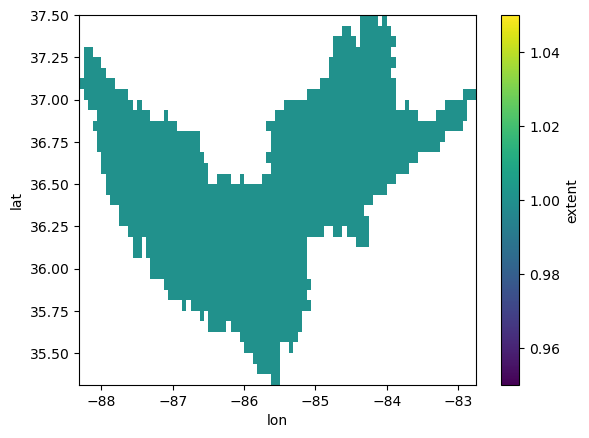

In [22]:
combined_nc_res['extent'].plot()

In [23]:
combined_nc_res.to_netcdf(ncpath)

# Read combined data

In [24]:
res_ds = xr.open_dataset("/water2/pdas47/2023_01_24-river-regulation/data-precip-analysis/tennessee/basins/cumberland/pre_processing/nc/combined_data.nc")
res_ds

<xarray.Dataset>
Dimensions:  (time: 1734, lat: 35, lon: 89)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2021-09-30
  * lat      (lat) float64 37.47 37.41 37.34 37.28 ... 35.53 35.47 35.41 35.34
  * lon      (lon) float64 -88.28 -88.22 -88.16 -88.09 ... -82.91 -82.84 -82.78
Data variables:
    precip   (time, lat, lon) float64 ...
    tmax     (time, lat, lon) float64 ...
    tmin     (time, lat, lon) float64 ...
    wind     (time, lat, lon) float64 ...
    extent   (lat, lon) float64 ...

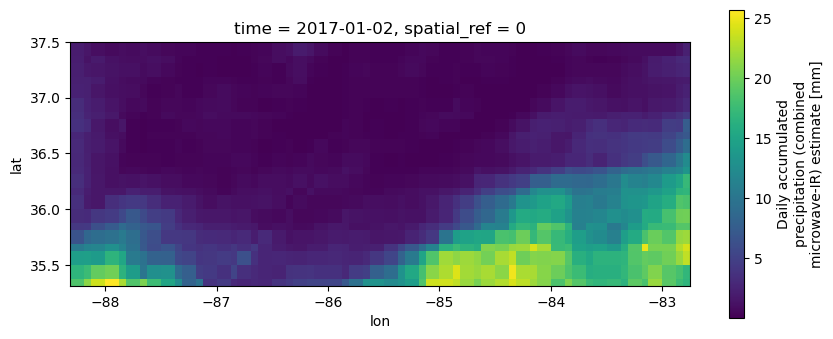

In [26]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(figsize=(10, 4))

res_ds['precip'].sel(time='2017-01-02', method='nearest').plot(x='lon', y='lat', ax=ax)
ax.set_aspect('equal')

In [27]:
from rat.run_rat import run_rat
from ruamel.yaml import YAML

config_fn = Path("../../params/rat-precip-analysis.yaml")

config_yaml = YAML()
config_yaml = config_yaml.load(config_fn.read_text())

start_date = config_yaml['BASIN']['start']
end_date = config_yaml['BASIN']['end']
# run_rat(config_fn)

/water2/pdas47/2023_01_24-river-regulation/models/RAT/src/rat/rat_basin.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [28]:
import datetime

def generate_state_and_inputs(forcings_startdate, forcings_enddate, combined_datapath, out_dir):
    combined_datapath = Path(combined_datapath)
    assert combined_datapath.exists()
    out_dir = Path(out_dir)
    out_dir.mkdir(exist_ok=True, parents=True)

    # Generate state. Assuming `nc_fmt_data` contains all the data, presumably containing enough data
    # to create state file (upto 90 days prior data from forcings_startdate)
    combined_data = xr.open_dataset(combined_datapath)

    state_startdate = forcings_startdate - datetime.timedelta(days=90)
    state_enddate = forcings_startdate - datetime.timedelta(days=1)

    state_ds = combined_data.sel(time=slice(state_startdate, state_enddate))
    state_outpath = out_dir / "state.nc"
    print(f"Saving state at: {state_outpath}")
    state_ds.drop('spatial_ref').to_netcdf(state_outpath)

    # Generate the metsim input
    forcings_ds = combined_data.sel(time=slice(forcings_startdate, forcings_enddate))
    forcings_outpath = out_dir / "metsim_input.nc"
    print(f"Saving forcings: {forcings_outpath}")
    forcings_ds.drop('spatial_ref').to_netcdf(forcings_outpath)

    return state_outpath, forcings_outpath

In [29]:
generate_state_and_inputs(
    start_date, 
    end_date, 
    "/water2/pdas47/2023_01_24-river-regulation/data-precip-analysis/tennessee/basins/cumberland/pre_processing/nc/combined_data.nc", 
    "/water2/pdas47/2023_01_24-river-regulation/data-precip-analysis/tennessee/basins/cumberland/metsim/metsim_inputs"
)

Saving state at: /water2/pdas47/2023_01_24-river-regulation/data-precip-analysis/tennessee/basins/cumberland/metsim/metsim_inputs/state.nc
Saving forcings: /water2/pdas47/2023_01_24-river-regulation/data-precip-analysis/tennessee/basins/cumberland/metsim/metsim_inputs/metsim_input.nc


(PosixPath('/water2/pdas47/2023_01_24-river-regulation/data-precip-analysis/tennessee/basins/cumberland/metsim/metsim_inputs/state.nc'),
 PosixPath('/water2/pdas47/2023_01_24-river-regulation/data-precip-analysis/tennessee/basins/cumberland/metsim/metsim_inputs/metsim_input.nc'))

In [30]:
import xarray as xr
from pathlib import Path

KeyError: 'precip'

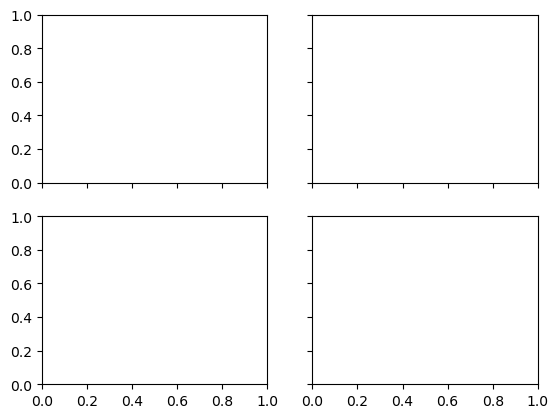

In [31]:
from matplotlib import pyplot as plt

t = '2019-01-04'

f, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

imerg_ds['precip'].sel(time=t, method='nearest').plot(ax=ax[0, 0], cmap='Blues')
imerg_ds['wind'].sel(time=t, method='nearest').plot(ax=ax[0, 1], cmap='inferno')
imerg_ds['tmax'].sel(time=t, method='nearest').plot(ax=ax[1, 1], cmap='RdYlBu_r')
imerg_ds['tmin'].sel(time=t, method='nearest').plot(ax=ax[1, 0], cmap='RdYlBu_r')

# remove axis titles, set figure suptitle and adjust axis spacing
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('')
        ax[i, j].collections[0].colorbar.set_label('')

# set titles of each subplot
ax[0, 0].set_title('Precipitation (mm/day))')
ax[0, 1].set_title('Wind Speed (m/s)')
ax[1, 1].set_title('Max Temperature (C)')
ax[1, 0].set_title('Min Temperature (C)')

# set y-axis label on left plots, and x-axis label on bottom plots
ax[0, 0].set_ylabel('Latitude')
ax[1, 0].set_ylabel('Latitude')
ax[1, 0].set_xlabel('Longitude')
ax[1, 1].set_xlabel('Longitude')

f.suptitle(f"IMERG Data for {t}", fontsize=16)
f.tight_layout()

In [ ]:
def convert_to_vic_forcings(results_path, forcings_dir):
    forcings_dir = Path(forcings_dir)
    # The results have to be converted to VIC readable yearly netcdf files.
    ds = xr.open_dataset(results_path, chunks='auto').load()
    
    years, dataset = zip(*ds.groupby('time.year'))
    paths = [forcings_dir / f'forcing_{y}.nc' for y in years]

    #Create directory if doesn't exist
    forcings_dir.mkdir(exist_ok=True, parents=True)

    print(f"Will create {len(years)} forcing files")
    for year, ds, p in zip(years, dataset, paths):
        if p.exists():
            existing = xr.open_dataset(p).load()
            existing.close()

            print(f"Writing file for year {year}: {p} -- Updating existing")
            last_existing_time = existing.time[-1]
            print("Existing data: %s", last_existing_time)
            ds = ds.sel(time=slice(last_existing_time + np.timedelta64(6,'h'), ds.time[-1]))
            xr.merge([existing, ds]).to_netcdf(p)
        else:
            print(f"Writing file for year {year}: {p} -- Updating new")
            ds.to_netcdf(p)

In [ ]:
convert_to_vic_forcings()